# L4d: Kernel Regression in Finance
In this lab, we will implement kernel regression, a non-parametric method for regression analysis on time-series financial data. 

> __Learning Objectives__
> 
> By the end of this lab, you should be able to:
>
> Three learning objectives go here.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
We gathered a daily open-high-low-close dataset for each firm in the S&P 500 from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Finally, let's get a list of the firms in our cleaned dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort # list of firm "ticker" symbols in alphabetical order

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 ⋮
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

___

## Task 1: Exponential Moving Average (EMA) of Share Price
In this task, we will compute the exponential moving average (EMA) of the share price for each firm in our dataset. The EMA is a type of moving average that gives more weight to recent prices, making it more responsive to new information.

Let's start by choosing a ticker symbol from our `list_of_tickers` variable and save it in the `my_ticker::String` variable.

In [6]:
my_ticker = "AAPL"; # choose a ticker symbol from the list_of_tickers variable

Next, let's get the volume weighted average price (VWAP) for the ticker in our dataset and save it in the `vwap::Array{Float64,1}` variable. The VWAP is a trading benchmark that gives the average price a security has traded at throughout the day, based on both volume and price.

In [7]:
vwap = dataset[my_ticker][!, :volume_weighted_average_price] |> collect; # get the VWAP for the ticker in our dataset

> __What is an Exponential Moving Average (EMA)?__ An EMA is a type of moving average that places a greater weight and significance on the most recent data points. The formula for calculating the EMA at time $t$ is given by:
> $$
\begin{align*}
EMA_t &= \alpha \cdot P_t + (1 - \alpha) \cdot EMA_{t-1}\quad \text{for } t > N - 1\;\text{and}\;\alpha = \frac{2}{N + 1}\\
\end{align*}
$$
> where: $P_t$ is the price at time $t$, $EMA_{t-1}$ is the EMA at the previous time step, and $N$ is the number of periods, e.g., days over which the EMA is calculated. The smoothing factor $\alpha$ determines how much weight is given to the most recent price.


We'll store these moving averages in the `EMA_data::Array{Float64,2}` variable.

In [25]:
EMA_data, N = let

    # initialize -
    N = 252; # N-day EMA window size (units: days)
    S = vwap; # share price (USD/share) for the ticker in our dataset
    length_of_S = length(S); # number of trading days in our dataset for the ticker
    EMA_array = Array{Float64,2}(undef, length_of_S, 2); # col 1: time, col 2: EMA (USD/share)

    # compute: EMA smoothing factor -
    α = 2.0 / (N + 1.0); # short-term smoothing factor

    # warmup: initialize EMA_array with raw prices during warmup period -
    for t ∈ 1:(N - 1)
        EMA_array[t,1] = t; 
        EMA_array[t,2] = S[t]; # use raw price until enough data available
    end

    # compute: exponential moving averages -
    for t ∈ 1:length_of_S
        
        # short-term EMA: EMA(t) = α*P(t) + (1-α)*EMA(t-1)
        if t >= N
            EMA_array[t,1] = t;
            EMA_array[t,2] = α*S[t] + (1 - α)*EMA_array[t - 1, 2];
        end
    end

    EMA_array, N; # return the EMA data array and the window size N
end;

__Visualize:__ Plot the observed volume weighted average price alongside the exponential moving average. 

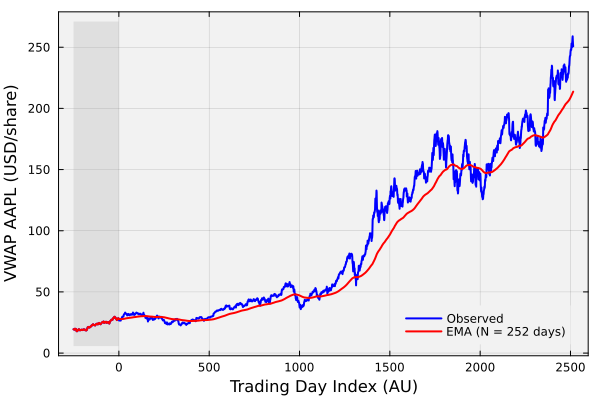

In [ ]:
let

    # initialize -
    S = vwap; # share price (USD/share) for the ticker in our dataset 
    offset = N; # offset to account for moving average buffer
        
    # compute the "warmup box" for the pre-history period (time < 0)
    xvals = EMA_data[:,1] .- offset; # shifted time axis
    y_min, y_max = extrema(vcat(S, EMA_data[:,2])); # find min and max price for plotting
    y_pad = max(0.05 * (y_max - y_min), 1.0e-6);
    y_low = y_min - y_pad;
    y_high = y_max + y_pad;

    # plot with single shaded pre-history block (time < 0) -
    plt = plot(xlabel = "Time Step (Days)", ylabel = "Synthetic SPY Price (USD/share)");
    x_left = minimum(xvals);
    x_right = 0.0;
    plot!(plt, Shape([x_left, x_right, x_right, x_left], [y_low, y_low, y_high, y_high]);
          color = :darkgray, alpha = 0.25, linealpha = 0, label = false);


    plot!(EMA_data[:,1] .- offset, vwap, label="Observed", color=:blue, linewidth=2)
    plot!(EMA_data[:,1] .- offset, EMA_data[:,2], label="EMA (N = $(N) days)", color=:red, linewidth=2)
    plot!(plt, bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Trading Day Index (AU)", fontsize=18)
    ylabel!("VWAP $(my_ticker) (USD/share)", fontsize=18)   

end

## Summary
One direct, concise summary sentence goes here.

> __Key Takeaway__
>
> Three key takeaways go here.

One direct, concise concluding sentence goes here.
___